In [1]:
import tensorflow as tf 
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
mnist=input_data.read_data_sets(train_dir="MNIST_data",one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline 

# showing some example of the training data

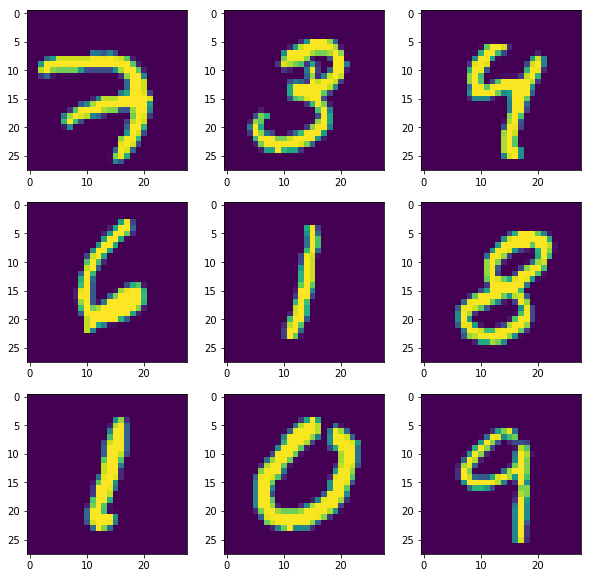

In [4]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
i=0
for r in range(3):
    for c in range(3):
        axs[r,c].imshow(mnist.train.images[i].reshape([28,28]))
        i+=1


# creating the helper functions

In [ ]:
#INIT WEIGHTS
def init_weights(shape,stddev=0.1):
    #shape:  shape of the weight matrix
    #stddev: the standard deviation of the gausian random itialization of weights
    init_random_matrix=tf.truncated_normal(shape=shape,stddev=0.1)
    return tf.Variable(initial_value=init_random_matrix)
#pass

In [ ]:
# INIT BIAS
def init_bias(shape):
    init_bias_vals=tf.constant(value=0.1,shape=shape)
    return tf.Variable(initial_value=init_bias_vals)

In [ ]:
#CONV2D
def conv2d(input_tensor,kernal_weights,strides=[1,1,1,1]):
    #input_tensor is the image or a convoulution of image , it takes[batch_size,Heigh,Width,Color_Channels]
    
    #Kernal it is the filter representing the convolution layer , it takes [filter H ,filter W,Channels IN,CHANNELS OUT]
    
    #Channels IN : when dealling with input from image it's channels will be 3  which are the colors, but when dealing with 
    #input from convolution the channels will be layers of abstracted featers filtered by the previously constracted convolution
    
    #Channel OUT is the number of filters where :(every filter will output or recogize single feature )
    #strides shifting the cernal by stride number of pixels
    return tf.nn.conv2d(input=input_tensor,filter=kernal_weights,strides=strides,padding='SAME')
#pass

In [ ]:
#POOLING
def max_pool_2by2(input_tensor):
    #input_tensor is the image or a convoulution of image , it takes[batch_size,Heigh,Width,Color_Channels]
    return tf.nn.max_pool(input_tensor,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    #[1,2,2,1] to max pool by value of 2x2 pixels but not pooling from 2 ifferey batches or channels

#pass

In [ ]:
#convolution layer
def convolution_layer(input_tensor,kernal):
    w=init_weights(kernal)
    b=init_bias([kernal[3]])
    return tf.nn.relu(conv2d(input_tensor,w)+b)
#pass

In [ ]:
# fully connected layer
#this layers takes the featerures abstracted by the convoulution layer and make the ordinary classification on it 
def fully_connected_layer(input_tensor,size):
    """
    #Kernal it is the filter representing the convolution layer , it takes [filter H ,filter W,Channels IN,CHANNELS OUT]
    
    #Channels IN : when dealling with input from image it's channels will be 3  which are the colors, but when dealing with 
    #input from convolution the channels will be layers of abstracted featers filtered by the previously constracted convolution
    
    #Channel OUT is the number of filters where :(every filter will output or recogize single feature )
    """
    input_shape=int(input_tensor.get_shape()[1])
    
    w=init_weights([input_shape,size])
    b=init_bias(shape=[size])
    return tf.add(tf.matmul(input_tensor,w),b)
#pass

# CREATING THE MODEL

In [ ]:
#placeholders
in_images=tf.placeholder(tf.float32,shape=[None,784])
real_n=tf.placeholder(tf.float32,shape=[None,10])
drop_out_ph=tf.placeholder(tf.float32)
#pass

In [ ]:
# LAYERS (model)
reshaped_image=tf.reshape(in_images,[-1,28,28,1])
#[-1,28,28,1]
#-1 for unknown batch size
#28,28 the  image size
#1 for the color channel shape 1 for gray scale as the data sit is in gray scale

CNL_1=convolution_layer(reshaped_image,kernal=[6,6,1,32])
pooling_layer1=max_pool_2by2(CNL_1)



CNL_2=convolution_layer(pooling_layer1,kernal=[6,6,32,64])
pooling_layer2=max_pool_2by2(CNL_2)

pooling2flat=tf.reshape(pooling_layer2,[-1,7*7*64])#-1 batch size #784 image size  # 2*2 number of pooling *2 #64 n of features  
DNN_1=tf.nn.relu( fully_connected_layer(pooling2flat,1024))
drop_out_DNN_1=tf.nn.dropout(DNN_1,keep_prob=drop_out_ph)
DNN_learned_n=fully_connected_layer(drop_out_DNN_1,10)
#pass



$$cross entropy=-\sum_{i=0}^\infty L \log{S} $$
#####  where 
######          L is the lables (hot incoded array of 10) 
######          S is the segmoid function output  (probabilty array of 10) 
https://en.wikipedia.org/wiki/Cross_entropy

In [54]:
# LOSS FUNCTION
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=real_n,logits=DNN_learned_n))

In [57]:
# OPTIMIZER
optimizer=tf.train.AdamOptimizer()

train=optimizer.minimize(cross_entropy)

In [58]:
#SESSION
saver = tf.train.Saver()
from tqdm import tqdm
init=tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    steps = 5000
    batch_size=100
    for i in range(steps):
        img,labels = mnist.train.next_batch(50)
        
        sess.run(train,feed_dict={in_images:img,real_n:labels,drop_out_ph:0.5})
        
        if i % 100 == 0:
            matches =tf.equal(tf.argmax(DNN_learned_n,1),tf.arg_max(real_n,1))
            accuracy=tf.reduce_mean(tf.cast(matches,tf.float32))
            print("step:",i)
            print("model accuracy : ",sess.run(accuracy,feed_dict={real_n:mnist.test.labels,in_images:mnist.test.images,drop_out_ph:1.0}))
        
    saver.save(sess,"mnist_cnn/cnn_mnist.ckpt")
    

step: 0
model accuracy :  0.1031
step: 100
model accuracy :  0.9424
step: 200
model accuracy :  0.9606
step: 300
model accuracy :  0.9683
step: 400
model accuracy :  0.9721
step: 500
model accuracy :  0.972
step: 600
model accuracy :  0.9774
step: 700
model accuracy :  0.9777
step: 800
model accuracy :  0.9793
step: 900
model accuracy :  0.9834
step: 1000
model accuracy :  0.9853
step: 1100
model accuracy :  0.984
step: 1200
model accuracy :  0.984
step: 1300
model accuracy :  0.9861
step: 1400
model accuracy :  0.9868
step: 1500
model accuracy :  0.985
step: 1600
model accuracy :  0.9839
step: 1700
model accuracy :  0.9856
step: 1800
model accuracy :  0.9856
step: 1900
model accuracy :  0.9836
step: 2000
model accuracy :  0.9859
step: 2100
model accuracy :  0.9871
step: 2200
model accuracy :  0.9863
step: 2300
model accuracy :  0.9852
step: 2400
model accuracy :  0.9883
step: 2500
model accuracy :  0.9879
step: 2600
model accuracy :  0.9904
step: 2700
model accuracy :  0.9887
step: 28

In [59]:
with tf.Session() as sess:
    saver.restore(sess,"mnist_cnn/cnn_mnist.ckpt")
    output = tf.argmax(DNN_learned_n,1)
    predicted=sess.run(output,feed_dict={in_images:mnist.test.images[0:10],drop_out_ph:1.0})
    print(predicted)
    

INFO:tensorflow:Restoring parameters from mnist_cnn/cnn_mnist.ckpt
[7 2 1 0 4 1 4 9 5 9]


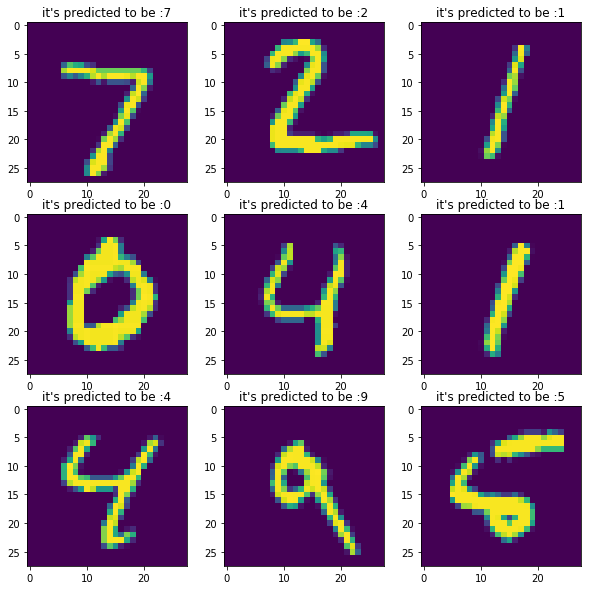

In [60]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
#plt.imshow(mnist.test.images[i].reshape([28,28]))
i=0
for r in range(3):
    for c in range(3):
        plt.subplot(3,3,i+1).set_title("it's predicted to be :"+str(predicted[i]))
        plt.subplot(3,3,i+1).imshow(mnist.test.images[i].reshape([28,28]))

        

        i+=1